# Batch Learning

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

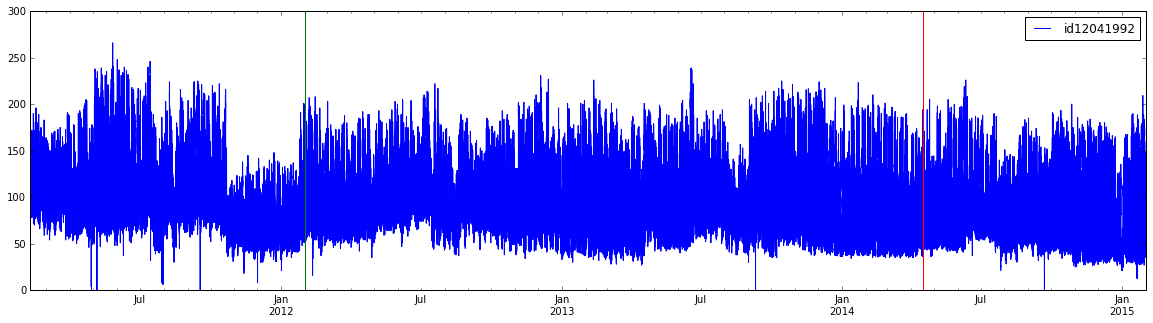

In [4]:
f = original_data[["id12041992"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

Testing how to iterate day by day

In [7]:
from datetime import timedelta

splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
splitting_time = splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
latest_time = original_data.iloc[[-1]].index.to_pydatetime()[0]
    
while (splitting_time < latest_time):
    
    eval_start_time = splitting_time
    splitting_time = splitting_time + timedelta(days=1)
    eval_end_time = splitting_time

    print "\n", eval_start_time, eval_end_time
    
    data[:eval_start_time - timedelta(minutes=15)].info()
    data[eval_start_time:eval_end_time].info()
    print splitting_time
    


2014-04-17 00:00:00 2014-04-18 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77376 entries, 2012-02-01 00:00:00 to 2014-04-16 23:45:00
Columns: 535 entries, id14061671 to Holiday_sum
dtypes: float64(526), int64(9)
memory usage: 316.4 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2014-04-17 00:00:00 to 2014-04-18 00:00:00
Columns: 535 entries, id14061671 to Holiday_sum
dtypes: float64(526), int64(9)
memory usage: 406.2 KB
2014-04-18 00:00:00

2014-04-18 00:00:00 2014-04-19 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77472 entries, 2012-02-01 00:00:00 to 2014-04-17 23:45:00
Columns: 535 entries, id14061671 to Holiday_sum
dtypes: float64(526), int64(9)
memory usage: 316.8 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2014-04-18 00:00:00 to 2014-04-19 00:00:00
Columns: 535 entries, id14061671 to Holiday_sum
dtypes: float64(526), int64(9)
memory usage: 406.2 KB
2014-04-19 00:00:00

2014-04-19 00:00:00 2014-04-20 

# Define Machine Learning Models and Data Sets

In [6]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
#from neural_network import PyBrainNN

C:\Python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Creating Feature Sets

In [7]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [8]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [9]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [41]:
horizons = range(1,25)

baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [#{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          #{'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             #{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 #{'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

Original data (not data). Baselines added to vector each day (causes slight deviation).

In [83]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0])
            #splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_point = int(0.8 * original_data.shape[0])
            splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            # batch approach
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])
                            
                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test)
                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data[bl.target])
                            
#                     else:
#                         for model in models: 
#                             # Initializing model
#                             mdl = eval(model['init'])

#                             # Model leraning
#                             start = time.time() # Start measuring time
#                             if model['name'] == "Ridge Regression":
#                                 mdl.fit(X_train_dummy, y_train_dummy)
#                             else:
#                                 mdl.fit(X_train,y_train)
#                             runtime = time.time() - start # Calculate runtime

#                             if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
#                             if model['name'] == "Ridge Regression":
#                                 validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
#                                 validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
#                             else:                               
#                                 validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
#                                 validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))

            # evaluation
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        for metric in error_metrics:
                            true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print validation_df


start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

output_file_name = "testni_eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 1h. Shifting runtime: 0.73s

		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77376L, 20L), y_train: (77376L,)

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77472L, 20L), y_train: (77472L,)

		-->Evaluation (2014-04-20 00:00:00)
			-->Dataset: Baselines. X_train: (77568L, 16L), y_train: (77568L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77568L, 20L), y_train: (77568L,)

		-->Evaluation (2014-04-21 00:00:00)
			-->Dataset: Baselines. X_train: (77664L, 16L), y_train: (77664L,)
				-->Computing 

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [84]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous day  Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous week Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[57.4, 57.0, 40.2, 43.0, 40.1, 43.0, 36.6, 40...   
        Previous week Baselines      [[41.0, 49.1, 41.0, 44.1, 42.1, 45.1, 42.3, 45...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                               
results                                    R2        MAE       MAPE  
horizon dataset       model                                          
1.0     Last value    Baselines      0.638174  15.828031  18.575044  
        Previous day  Baselines      0.384555  19.849139  23.404569  
        Previous week Baselines      0.548890  17.345007  20.376291  
        TOP_20        Random Forest       NaN        NaN        NaN

Original data (not data). Baselines computed only once.

In [86]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            # baseline data
            training_data_bl = sensor_data[:original_splitting_time]
            testing_data_bl = sensor_data[original_splitting_time:]
            y_test_bl = testing_data_bl[["shifted_measurement"]].values.ravel()
            
            # batch approach
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            #bl = eval(baseline['init'])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test_bl)
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data_bl[bl.target])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                            
                    else:
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
                            if model['name'] == "Ridge Regression":
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
                            else:                               
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))

            # evaluation
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        bl = eval(baseline['init'])
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                        
                        for metric in error_metrics:
                            true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print validation_df


start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

output_file_name = "testni_eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 1h. Shifting runtime: 0.72s

		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77376L, 20L), y_train: (77376L,)
				-->Training model: Random Forest, runtime: 7.20s

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77472L, 20L), y_train: (77472L,)
				-->Training model: Random Forest, runtime: 7.35s

		-->Evaluation (2014-04-20 00:00:00)
			-->Dataset: Baselines. X_train: (77568L, 16L), y_train: (77568L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77568L, 20L), y_train: (77568L,)
				-->Training mod

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required.

In [87]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous day  Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous week Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        TOP_20        Random Forest  [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
2.0     Last value    Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous day  Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous week Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        TOP_20        Random Forest  [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
3.0     Last value    Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous day  Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous week Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        TOP_20        Random Forest  [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
4.0     Last value    Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous day  Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous week Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        TOP_20        Random Forest  [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
5.0     Last value    Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous day  Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous week Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        TOP_20        Random Forest  [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
6.0     Last value    Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous day  Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous week Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        TOP_20        Random Forest  [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
7.0     Last value    Baselines                                                   [[]]   
        Previous day  Baselines                                                   [[]]   
        Previous week Baselines                                                   [[]]   
        TOP_20        Random Forest  [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 43.0, 36.6, 40.0, 40.1, 37.4, 41.1, 41...   
        Previous week Baselines      [[42.1, 45.1, 42.3, 45.1, 44.0, 52.6, 47.0, 50...   
        TOP_20        Random Forest  [[61.8818718868, 62.1185968766, 54.6203809776,...   
2.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 37.4, 41.1, 41.1, 40.5, 55.0, 54.1, 54...   
        Previous week Baselines      [[44.0, 52.6, 47.0, 50.2, 49.0, 57.2, 59.0, 53...   
        TOP_20        Random Forest  [[42.9315089878, 43.9406555744, 42.5107856437,...   
3.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.5, 55.0, 54.1, 54.0, 70.2, 63.4, 72.2, 65...   
        Previous week Baselines      [[

In [82]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous day  Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous week Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[57.4, 57.0, 40.2, 43.0, 40.1, 43.0, 36.6, 40...   
        Previous week Baselines      [[41.0, 49.1, 41.0, 44.1, 42.1, 45.1, 42.3, 45...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                               
results                                    R2        MAE       MAPE  
horizon dataset       model                                          
1.0     Last value    Baselines      0.636684  15.875924  18.577076  
        Previous day  Baselines      0.381451  19.918373  23.415252  
        Previous week Baselines      0.546953  17.399943  20.381010  
        TOP_20        Random Forest       NaN        NaN        NaN

In [47]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[112.5, 117.5, 112.4, 118.5, 102.1, 119.0, 93...   
        Previous day  Baselines      [[112.5, 117.5, 112.4, 118.5, 102.1, 119.0, 93...   
        Previous week Baselines      [[112.5, 117.5, 112.4, 118.5, 102.1, 119.0, 93...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[185.3, 169.3, 154.3, 127.5, 112.5, 117.5, 11...   
        Previous day  Baselines      [[99.1, 115.0, 98.0, 114.1, 90.0, 95.2, 98.2, ...   
        Previous week Baselines      [[116.0, 116.4, 105.0, 121.0, 106.1, 112.0, 11...   
        TOP_20        Random Forest                                               [[]]   

sensor                                                               
results                                    R2        MAE       MAPE  
horizon dataset       model                                          
1.0     Last value    Baselines      0.624992  16.340600  19.747407  
        Previous day  Baselines      0.365942  20.612983  25.127317  
        Previous week Baselines      0.530951  17.933178  21.839691  
        TOP_20        Random Forest       NaN        NaN        NaN

### old code

In [112]:
horizons = range(7,9)

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            # baseline data
            training_data_bl = sensor_data[:original_splitting_time]
            testing_data_bl = sensor_data[original_splitting_time:]
            y_test_bl = testing_data_bl[["shifted_measurement"]].values.ravel()
            
            # batch approach
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            #bl = eval(baseline['init'])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test_bl)
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data_bl[bl.target])
                            
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                            
                    else:
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])
                            
                            print "X_train", X_train.shape
                            print "y_train", y_train.shape

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
                            if model['name'] == "Ridge Regression":
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
                            else:                               
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))

            # evaluation
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        bl = eval(baseline['init'])
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test_bl]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data_bl[bl.target]]).values
                        
                        for metric in error_metrics:
                            true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                            error = metric['function'](true, pred)

                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print validation_df


start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

output_file_name = "testni_eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 7h. Shifting runtime: 0.74s

		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77376L, 20L), y_train: (77376L,)
X_train (77376L, 20L)
y_train (77376L,)
				-->Training model: Random Forest, runtime: 7.54s

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (77472L, 20L), y_train: (77472L,)
X_train (77472L, 20L)
y_train (77472L,)
				-->Training model: Random Forest, runtime: 7.54s

		-->Evaluation (2014-04-20 00:00:00)
			-->Dataset: Baselines. X_train: (77568L, 16L), y_train: (77568L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			--

In [113]:
validation_dftion_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
7.0     Last value    Baselines      [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   
        Previous day  Baselines      [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   
        Previous week Baselines      [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   
        TOP_20        Random Forest  [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   
8.0     Last value    Baselines      [[137.1, 111.0, 154.0, 132.2, 114.0, 139.0, 14...   
        Previous day  Baselines      [[137.1, 111.0, 154.0, 132.2, 114.0, 139.0, 14...   
        Previous week Baselines      [[137.1, 111.0, 154.0, 132.2, 114.0, 139.0, 14...   
        TOP_20        Random Forest  [[137.1, 111.0, 154.0, 132.2, 114.0, 139.0, 14...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
7.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[132.3, 120.1, 128.0, 130.1, 136.0, 134.0, 11...   
        Previous week Baselines      [[103.1, 127.0, 125.1, 117.0, 119.0, 125.1, 11...   
        TOP_20        Random Forest  [[112.690958017, 126.257113778, 130.379677187,...   
8.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[132.3, 120.1, 128.0, 130.1, 136.0, 134.0, 11...   
        Previous week Baselines      [[103.1, 127.0, 125.1, 117.0, 119.0, 125.1, 11...   
        TOP_20        Random Forest  [[121.129108608, 122.302569912, 124.71725122, ...   

sensor                                                               
results                                    R2        MAE       MAPE  
horizon dataset       model                                          
7.0     Last value    Baselines     -1.064749  41.852619  52.868182  
        Previous day  Baselines      0.380736  19.929680  23.426365  
        Previous week Baselines      0.546536  17.404422  20.381699  
        TOP_20        Random Forest  0.750533  13.424060  16.793113  
8.0     Last value    Baselines     -1.339375  45.239999  57.491787  
        Previous day  Baselines      0.380743  19.928566  23.426321  
        Previous week Baselines      0.546727  17.402310  20.385182  
        TOP_20        Random Forest  0.749267  13.458846  16.772096

Uses data (not original_data). Baselines added to vector each day (causes slight deviation).

In [34]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'results'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            splitting_point = int(0.8 * data.shape[0])
            splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            # Init results df
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values  
                else:
                    for model in models:
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([[]]).values
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([[]]).values
            
            
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])
                            
                            #validation_df_loc_true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')]
                            #validation_df_loc_pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')]
                            
                                                        
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')] = pd.Series([y_test]).values
                            #validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')] = pd.Series([testing_data[bl.target]]).values
                            
                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0].extend(y_test)
                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0].extend(testing_data[bl.target])

                            """
                            # NO NEED FOR EVALUATIONS AT THIS POINT
                            for metric in error_metrics:
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                               y_test, testing_data[bl.target])
                                else:
                                    error = metric['function'](y_test, testing_data[bl.target])

                                validation_df.loc[(horizon, splitting_time, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                            """
                            
                    else:
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)
                                                       
                            if model['name'] == "Ridge Regression":
                                #validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([y_test_dummy]).values
                                #validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([mdl.predict(X_test_dummy)]).values
                                
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test_dummy)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test_dummy))
                            else:
                                #validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')] = pd.Series([y_test]).values
                                #validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')] = pd.Series([mdl.predict(X_test)]).values
                                
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0].extend(y_test)
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0].extend(mdl.predict(X_test))
                            
                            """
                            # NO NEED FOR EVALUATIONS AT THIS POINT
                            for metric in error_metrics:
                                #print "\t-->Error metric: {}".format(metric['name'])

                                if model['name'] == "Ridge Regression":
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                                   y_test_dummy, mdl.predict(X_test_dummy))
                                    else:
                                        error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                                else: 
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                                   y_test, mdl.predict(X_test))
                                    else:
                                        error = metric['function'](y_test, mdl.predict(X_test))

                                #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                                validation_df.loc[(horizon, splitting_time, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                            """
            
            
            print "\n\n\n\n\n\n\nFinished with one horizon\n\n\n\n\n\n\n"
            
            for data_set in data_sets:
                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        for metric in error_metrics:
                            if metric['short'] == 'MASE': # Ignored
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                true = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'true')][0]
                                pred = validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, 'predicted')][0]
                            
                                error = metric['function'](true, pred)

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                else:
                    for model in models: 
                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])
                            
                            true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
                            pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]

                            error = metric['function'](true, pred)

#                             if model['name'] == "Ridge Regression":
#                                 if metric['short'] == 'MASE': # Ignored
#                                     error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
#                                                                y_test_dummy, mdl.predict(X_test_dummy))
#                                 else:
#                                     true = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'true')][0]
#                                     pred = validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, 'predicted')][0]
                                
#                                     error = metric['function'](true, pred)

#                             else: 
#                                 if metric['short'] == 'MASE':
#                                     error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
#                                                                y_test, mdl.predict(X_test))
#                                 else:
#                                     error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                    
                                
            print validation_df
            
            #break
                            

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

output_file_name = "testni_eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 1h. Shifting runtime: 0.77s

		-->Evaluation (2014-06-28 00:00:00)
			-->Dataset: Baselines. X_train: (84192L, 16L), y_train: (84192L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (84192L, 20L), y_train: (84192L,)
				-->Training model: Random Forest, runtime: 9.08s

		-->Evaluation (2014-06-29 00:00:00)
			-->Dataset: Baselines. X_train: (84288L, 16L), y_train: (84288L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (84288L, 20L), y_train: (84288L,)
				-->Training model: Random Forest, runtime: 9.04s

		-->Evaluation (2014-06-30 00:00:00)
			-->Dataset: Baselines. X_train: (84384L, 16L), y_train: (84384L,)
				-->Computing Last value
				-->Computing Previous day
				-->Computing Previous week
			-->Dataset: TOP_20. X_train: (84384L, 20L), y_train: (84384L,)
				-->Training mod

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required.

In [35]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[64.0, 61.2, 66.3, 76.1, 71.5, 65.2, 55.0, 58...   
        Previous day  Baselines      [[64.0, 61.2, 66.3, 76.1, 71.5, 65.2, 55.0, 58...   
        Previous week Baselines      [[64.0, 61.2, 66.3, 76.1, 71.5, 65.2, 55.0, 58...   
        TOP_20        Random Forest  [[64.0, 61.2, 66.3, 76.1, 71.5, 65.2, 55.0, 58...   
2.0     Last value    Baselines      [[71.5, 65.2, 55.0, 58.2, 65.0, 62.1, 65.1, 63...   
        Previous day  Baselines      [[71.5, 65.2, 55.0, 58.2, 65.0, 62.1, 65.1, 63...   
        Previous week Baselines      [[71.5, 65.2, 55.0, 58.2, 65.0, 62.1, 65.1, 63...   
        TOP_20        Random Forest  [[71.5, 65.2, 55.0, 58.2, 65.0, 62.1, 65.1, 63...   
3.0     Last value    Baselines      [[65.0, 62.1, 65.1, 63.2, 61.0, 70.2, 70.3, 65...   
        Previous day  Baselines      [[65.0, 62.1, 65.1, 63.2, 61.0, 70.2, 70.3, 65...   
        Previous week Baselines      [[65.0, 62.1, 65.1, 63.2, 61.0, 70.2, 70.3, 65...   
        TOP_20        Random Forest  [[65.0, 62.1, 65.1, 63.2, 61.0, 70.2, 70.3, 65...   
4.0     Last value    Baselines      [[61.0, 70.2, 70.3, 65.2, 68.0, 73.2, 71.0, 81...   
        Previous day  Baselines      [[61.0, 70.2, 70.3, 65.2, 68.0, 73.2, 71.0, 81...   
        Previous week Baselines      [[61.0, 70.2, 70.3, 65.2, 68.0, 73.2, 71.0, 81...   
        TOP_20        Random Forest  [[61.0, 70.2, 70.3, 65.2, 68.0, 73.2, 71.0, 81...   
5.0     Last value    Baselines      [[68.0, 73.2, 71.0, 81.0, 84.1, 109.0, 103.1, ...   
        Previous day  Baselines      [[68.0, 73.2, 71.0, 81.0, 84.1, 109.0, 103.1, ...   
        Previous week Baselines      [[68.0, 73.2, 71.0, 81.0, 84.1, 109.0, 103.1, ...   
        TOP_20        Random Forest  [[68.0, 73.2, 71.0, 81.0, 84.1, 109.0, 103.1, ...   
6.0     Last value    Baselines      [[84.1, 109.0, 103.1, 108.1, 102.0, 109.3, 114...   
        Previous day  Baselines      [[84.1, 109.0, 103.1, 108.1, 102.0, 109.3, 114...   
        Previous week Baselines      [[84.1, 109.0, 103.1, 108.1, 102.0, 109.3, 114...   
        TOP_20        Random Forest  [[84.1, 109.0, 103.1, 108.1, 102.0, 109.3, 114...   
7.0     Last value    Baselines      [[102.0, 109.3, 114.0, 123.1, 117.1, 129.0, 12...   
        Previous day  Baselines      [[102.0, 109.3, 114.0, 123.1, 117.1, 129.0, 12...   
        Previous week Baselines      [[102.0, 109.3, 114.0, 123.1, 117.1, 129.0, 12...   
        TOP_20        Random Forest  [[102.0, 109.3, 114.0, 123.1, 117.1, 129.0, 12...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[65.0, 59.2, 64.0, 60.2, 64.0, 61.2, 66.3, 76...   
        Previous day  Baselines      [[59.1, 61.1, 78.2, 72.0, 64.2, 54.3, 56.1, 62...   
        Previous week Baselines      [[78.2, 74.3, 62.1, 56.1, 58.0, 55.2, 59.4, 61...   
        TOP_20        Random Forest  [[67.3432317744, 65.9249741507, 67.8713948103,...   
2.0     Last value    Baselines      [[65.0, 59.2, 64.0, 60.2, 64.0, 61.2, 66.3, 76...   
        Previous day  Baselines      [[64.2, 54.3, 56.1, 62.5, 61.1, 66.1, 62.2, 61...   
        Previous week Baselines      [[58.0, 55.2, 59.4, 61.2, 63.1, 61.2, 48.0, 37...   
        TOP_20        Random Forest  [[62.8623187546, 63.5693336, 63.8879127254, 63...   
3.0     Last value    Baselines      [[65.0, 59.2, 64.0, 60.2, 64.0, 61.2, 66.3, 76...   
        Previous day  Baselines      [[61.1, 66.1, 62.2, 61.0, 61.2, 70.0, 73.1, 69...   
        Previous week Baselines      [[

In [36]:
output_file_name = "testni_eval_top20_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

### Evaluation results

In [101]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous day  Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous week Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        TOP_20        Random Forest  [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
2.0     Last value    Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous day  Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous week Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        TOP_20        Random Forest  [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
3.0     Last value    Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous day  Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous week Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        TOP_20        Random Forest  [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
4.0     Last value    Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous day  Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous week Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        TOP_20        Random Forest  [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
5.0     Last value    Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous day  Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous week Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        TOP_20        Random Forest  [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
6.0     Last value    Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous day  Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous week Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        TOP_20        Random Forest  [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
7.0     Last value    Baselines                                                   [[]]   
        Previous day  Baselines                                                   [[]]   
        Previous week Baselines                                                   [[]]   
        TOP_20        Random Forest  [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 43.0, 36.6, 40.0, 40.1, 37.4, 41.1, 41...   
        Previous week Baselines      [[42.1, 45.1, 42.3, 45.1, 44.0, 52.6, 47.0, 50...   
        TOP_20        Random Forest  [[61.8818718868, 62.1185968766, 54.6203809776,...   
2.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 37.4, 41.1, 41.1, 40.5, 55.0, 54.1, 54...   
        Previous week Baselines      [[44.0, 52.6, 47.0, 50.2, 49.0, 57.2, 59.0, 53...   
        TOP_20        Random Forest  [[42.9315089878, 43.9406555744, 42.5107856437,...   
3.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.5, 55.0, 54.1, 54.0, 70.2, 63.4, 72.2, 65...   
        Previous week Baselines      [[

### Evaluation results averaged over all testing days

In [23]:
# validation_df['id12041992']['R2'][1.0].unstack()['Baselines'].unstack()['Last value'] # testing
validation_df.groupby(level=['horizon','dataset', 'model'], sort=False).mean()

sensor                              id12041992                                
error metric                                R2        MAE       MAPE      MASE
horizon dataset       model                                                   
1.0     Last value    Baselines       0.508957  16.294739  19.738277  1.141670
        Previous day  Baselines      -0.463405  20.531834  25.092916  1.438767
        Previous week Baselines       0.011775  17.890916  21.838463  1.252257
        TOP_20        Random Forest   0.575835  12.394644  15.531299  0.868272
2.0     Last value    Baselines       0.173764  21.766391  26.844938  1.063473
        Previous day  Baselines      -0.487620  20.522658  25.121173  1.002824
        Previous week Baselines      -0.000692  17.879858  21.868915  0.872989
        TOP_20        Random Forest   0.394524  13.324601  17.042937  0.650917
3.0     Last value    Baselines      -0.108788  25.400457  31.445883  0.998967
        Previous day  Baselines      -0.470800  20.526126  25.110622  0.807296
        Previous week Baselines       0.009510  17.896056  21.877304  0.703713
        TOP_20        Random Forest   0.305636  13.471203  17.359612  0.529799
4.0     Last value    Baselines      -0.365297  28.593137  35.656417  0.961355
        Previous day  Baselines      -0.454070  20.522494  25.115438  0.689924
        Previous week Baselines       0.021349  17.901362  21.903315  0.601877
        TOP_20        Random Forest   0.253365  13.581762  17.567137  0.456631
5.0     Last value    Baselines      -0.694177  32.825058  41.825681  0.975429
        Previous day  Baselines      -0.432621  20.521140  25.114836  0.609772
        Previous week Baselines       0.033237  17.908485  21.915538  0.532119
        TOP_20        Random Forest   0.279814  13.697267  17.731659  0.406999
6.0     Last value    Baselines      -1.117910  37.424818  48.730688  0.994705
        Previous day  Baselines      -0.436366  20.535022  25.127003  0.545830
        Previous week Baselines       0.031177  17.911104  21.921110  0.476007
        TOP_20        Random Forest   0.172262  13.875029  18.063344  0.368766
7.0     Last value    Baselines      -1.456223  41.731184  54.411375  1.003685
        Previous day  Baselines      -0.442517  20.626374  25.189015  0.496126
        Previous week Baselines       0.031969  17.929815  21.857395  0.431186
        TOP_20        Random Forest   0.074759  14.038782  18.348920  0.337626

## Results analysis

In [103]:
validation_df

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous day  Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        Previous week Baselines      [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
        TOP_20        Random Forest  [[53.0, 43.1, 40.1, 37.1, 42.5, 38.1, 40.0, 37...   
2.0     Last value    Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous day  Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        Previous week Baselines      [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
        TOP_20        Random Forest  [[42.5, 38.1, 40.0, 37.1, 40.1, 38.3, 39.1, 36...   
3.0     Last value    Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous day  Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        Previous week Baselines      [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
        TOP_20        Random Forest  [[40.1, 38.3, 39.1, 36.1, 41.0, 50.2, 70.4, 82...   
4.0     Last value    Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous day  Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        Previous week Baselines      [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
        TOP_20        Random Forest  [[41.0, 50.2, 70.4, 82.2, 65.0, 71.2, 74.2, 65...   
5.0     Last value    Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous day  Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        Previous week Baselines      [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
        TOP_20        Random Forest  [[65.0, 71.2, 74.2, 65.1, 76.1, 98.0, 119.0, 1...   
6.0     Last value    Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous day  Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        Previous week Baselines      [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
        TOP_20        Random Forest  [[76.1, 98.0, 119.0, 112.0, 124.1, 151.0, 158....   
7.0     Last value    Baselines                                                   [[]]   
        Previous day  Baselines                                                   [[]]   
        Previous week Baselines                                                   [[]]   
        TOP_20        Random Forest  [[124.1, 151.0, 158.1, 184.2, 137.1, 111.0, 15...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 43.0, 36.6, 40.0, 40.1, 37.4, 41.1, 41...   
        Previous week Baselines      [[42.1, 45.1, 42.3, 45.1, 44.0, 52.6, 47.0, 50...   
        TOP_20        Random Forest  [[61.8818718868, 62.1185968766, 54.6203809776,...   
2.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.1, 37.4, 41.1, 41.1, 40.5, 55.0, 54.1, 54...   
        Previous week Baselines      [[44.0, 52.6, 47.0, 50.2, 49.0, 57.2, 59.0, 53...   
        TOP_20        Random Forest  [[42.9315089878, 43.9406555744, 42.5107856437,...   
3.0     Last value    Baselines      [[71.0, 72.1, 66.3, 66.2, 53.0, 43.1, 40.1, 37...   
        Previous day  Baselines      [[40.5, 55.0, 54.1, 54.0, 70.2, 63.4, 72.2, 65...   
        Previous week Baselines      [[

In [102]:
# read from csv
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1,2], header=[0,1])

test

sensor                                                                      id12041992  \
results                                                                           true   
horizon dataset       model                                                              
1.0     Last value    Baselines      [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous day  Baselines      [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        Previous week Baselines      [array([ 53. ,  43.1,  40.1, ...,  65.7,  62.9...   
        TOP_20        Random Forest  [ list([53.0, 43.100000000000001, 40.100000000...   
2.0     Last value    Baselines      [array([ 42.5,  38.1,  40. , ...,  71.3,  95.2...   
        Previous day  Baselines      [array([ 42.5,  38.1,  40. , ...,  71.3,  95.2...   
        Previous week Baselines      [array([ 42.5,  38.1,  40. , ...,  71.3,  95.2...   
        TOP_20        Random Forest  [ list([42.5, 38.100000000000001, 40.0, 37.100...   
3.0     Last value    Baselines      [array([  40.1,   38.3,   39.1, ...,   98. ,  ...   
        Previous day  Baselines      [array([  40.1,   38.3,   39.1, ...,   98. ,  ...   
        Previous week Baselines      [array([  40.1,   38.3,   39.1, ...,   98. ,  ...   
        TOP_20        Random Forest  [ list([40.100000000000001, 38.299999999999997...   
4.0     Last value    Baselines      [array([  41. ,   50.2,   70.4, ...,  110.9,  ...   
        Previous day  Baselines      [array([  41. ,   50.2,   70.4, ...,  110.9,  ...   
        Previous week Baselines      [array([  41. ,   50.2,   70.4, ...,  110.9,  ...   
        TOP_20        Random Forest  [ list([41.0, 50.200000000000003, 70.400000000...   
5.0     Last value    Baselines      [array([ 65. ,  71.2,  74.2, ...,  80.7,  75.7...   
        Previous day  Baselines      [array([ 65. ,  71.2,  74.2, ...,  80.7,  75.7...   
        Previous week Baselines      [array([ 65. ,  71.2,  74.2, ...,  80.7,  75.7...   
        TOP_20        Random Forest  [ list([65.0, 71.200000000000003, 74.200000000...   
6.0     Last value    Baselines      [array([  76.1,   98. ,  119. , ...,   77.9,  ...   
        Previous day  Baselines      [array([  76.1,   98. ,  119. , ...,   77.9,  ...   
        Previous week Baselines      [array([  76.1,   98. ,  119. , ...,   77.9,  ...   
        TOP_20        Random Forest  [ list([76.099999999999994, 98.0, 119.0, 112.0...   
7.0     Last value    Baselines                                             [list([])]   
        Previous day  Baselines                                             [list([])]   
        Previous week Baselines                                             [list([])]   
        TOP_20        Random Forest  [ list([124.09999999999999, 151.0, 158.0999999...   

sensor                                                                                  \
results                                                                      predicted   
horizon dataset       model                                                              
1.0     Last value    Baselines      [ 2014-04-17 00:00:00     71.0\r\n2014-04-17 0...   
        Previous day  Baselines      [ 2014-04-17 00:00:00     40.1\r\n2014-04-17 0...   
        Previous week Baselines      [ 2014-04-17 00:00:00     42.1\r\n2014-04-17 0...   
        TOP_20        Random Forest  [ list([61.881871886827895, 62.118596876572767...   
2.0     Last value    Baselines      [ 2014-04-17 00:00:00     71.0\r\n2014-04-17 0...   
        Previous day  Baselines      [ 2014-04-17 00:00:00     40.1\r\n2014-04-17 0...   
        Previous week Baselines      [ 2014-04-17 00:00:00     44.0\r\n2014-04-17 0...   
        TOP_20        Random Forest  [ list([42.93150898776139, 43.940655574374098,...   
3.0     Last value    Baselines      [ 2014-04-17 00:00:00     71.0\r\n2014-04-17 0...   
        Previous day  Baselines      [ 2014-04-17 00:00:00     40.5\r\n2014-04-17 0...   
        Previous week Baselines      [ 

In [149]:
test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']].mean()

dataset
TOP_20    0.575835
dtype: float64

In [214]:
test.xs(["Baselines"], level=["model"]).unstack()['id12041992']['R2'].join(
        test.xs(["TOP_20"], level=["dataset"]).unstack()['id12041992']['R2']).loc[1]

Last value  Previous day  Previous week  Random Forest
testing_day                                                        
2014-06-28     0.591010      0.717247       0.525938       0.824376
2014-06-29     0.195606     -6.152736      -1.113039       0.288903
2014-06-30     0.575196      0.489490       0.393274       0.793814
2014-07-01     0.484461     -0.797943       0.606016       0.788293
2014-07-02     0.472400      0.559024       0.535193       0.723927
2014-07-03     0.462220      0.588972      -0.275254       0.694443
2014-07-04     0.278601      0.403564       0.720479       0.710182
2014-07-05     0.690746      0.599616       0.676653       0.839842
2014-07-06     0.411884     -6.229409       0.526675       0.441861
2014-07-07     0.546416      0.758123       0.759812       0.794668
2014-07-08     0.674561     -0.808991       0.722573       0.848172
2014-07-09     0.752376      0.540417       0.562018       0.857954
2014-07-10     0.496538      0.475943       0.317361       0.641523
2014-07-11     0.507271      0.084294       0.312838       0.700357
2014-07-12     0.472833      0.638945       0.671124       0.727444
2014-07-13     0.479496     -2.945378       0.719318       0.674658
2014-07-14    -0.163381     -0.205321      -0.078239       0.365349
2014-07-15     0.328573     -1.326770       0.669662       0.716630
2014-07-16     0.272855      0.578983       0.483689       0.574478
2014-07-17     0.501527      0.583649       0.541825       0.765921
2014-07-18     0.565450     -0.169163       0.756174       0.744594
2014-07-19     0.500831      0.324340       0.293113       0.642287
2014-07-20     0.113821     -1.039963       0.021756       0.470452
2014-07-21     0.262302     -9.153884       0.000513       0.035209
2014-07-22     0.538494     -1.242708       0.438450       0.682083
2014-07-23     0.433491     -1.650040      -3.653742       0.185858
2014-07-24     0.622469      0.641069      -1.345554       0.649744
2014-07-25     0.459194      0.306374       0.021132       0.709406
2014-07-26     0.463083      0.534417      -1.231386       0.690052
2014-07-27     0.567724     -1.316134      -0.812314       0.590406
...                 ...           ...            ...            ...
2015-01-04     0.714212      0.698225       0.756639       0.769219
2015-01-05     0.729553      0.499424       0.359829       0.763222
2015-01-06     0.617183     -0.412883      -0.255870       0.616728
2015-01-07     0.630586      0.583802       0.201090       0.791602
2015-01-08     0.684112      0.688492      -2.925891       0.785912
2015-01-09     0.730295      0.773392      -2.354928       0.848145
2015-01-10     0.819147      0.641021       0.061128       0.897879
2015-01-11     0.823281     -0.069284       0.764004       0.878733
2015-01-12     0.736674      0.323133       0.030542       0.753671
2015-01-13     0.806204      0.305664       0.283038       0.888822
2015-01-14     0.601776      0.673331       0.592157       0.759370
2015-01-15     0.350358      0.584507       0.609253       0.675227
2015-01-16     0.469047      0.594343       0.646893       0.761080
2015-01-17     0.403337      0.706457       0.630555       0.776745
2015-01-18     0.173209     -0.713502       0.573545       0.628831
2015-01-19     0.066261      0.329519       0.582446       0.605196
2015-01-20     0.527364     -0.114071       0.609047       0.785650
2015-01-21     0.538822      0.728911       0.572684       0.824023
2015-01-22     0.618972      0.751151       0.605717       0.787724
2015-01-23     0.565447      0.504607       0.684148       0.796058
2015-01-24     0.324543      0.254680       0.265488       0.630046
2015-01-25     0.270487     -0.953438       0.323717       0.602626
2015-01-26    -0.332572     -0.060905      -0.145189       0.369031
2015-01-27     0.662874     -0.052330       0.746790       0.853962
2015-01-28     0.455651      0.716019       0.657526       0.820939
2015-01-29     0.727766      0.685431       0.657849       0.837022
2

Ploting R2 evaluation results for each day of testing data. We can see that on particular bad day lowers the overall average drastically.

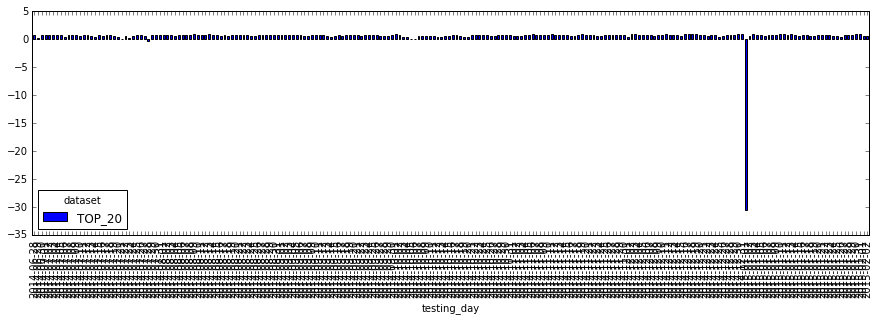

In [125]:
test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']].plot( kind='bar', figsize=(15,4))

Ploting evaluation results by ignoring negative R2 values. This is for horizon 1h into the future.

dataset
TOP_20    0.723405
dtype: float64

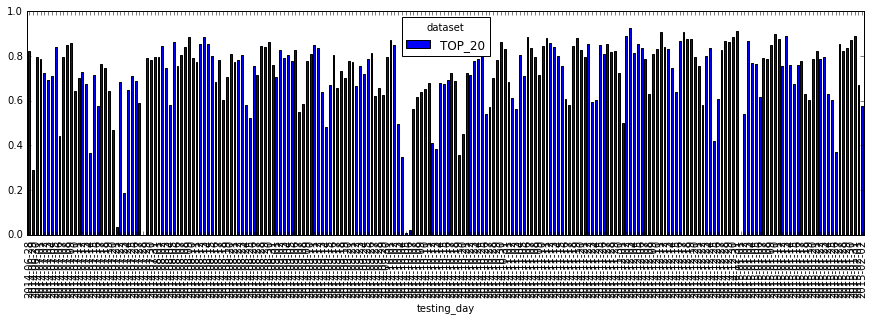

In [156]:
a = test.loc[1]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

3 hours into the future.

dataset
TOP_20    0.699797
dtype: float64

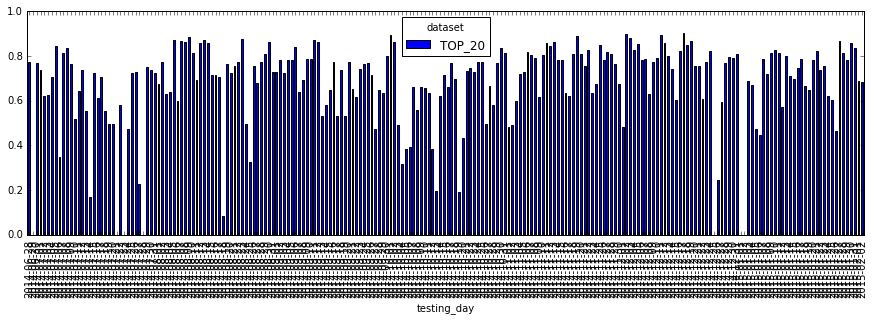

In [216]:
a = test.loc[3]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

5 hours into the future.

dataset
TOP_20    0.69128
dtype: float64

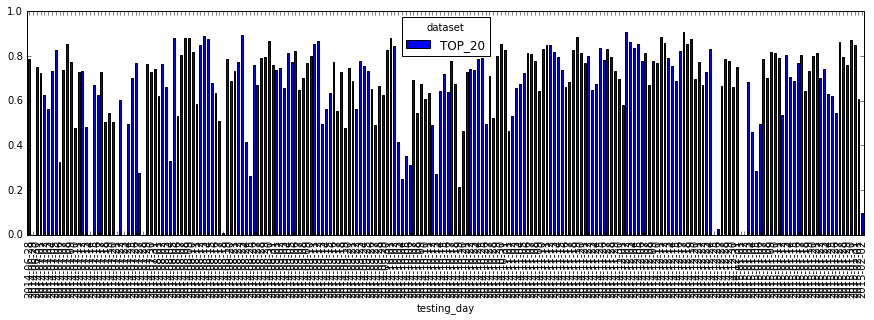

In [222]:
a = test.loc[5]['id12041992']['R2'].unstack()['Random Forest'].unstack()[['TOP_20']]
a[a > 0].plot( kind='bar', figsize=(15,4))
a[a > 0].mean()

## Old code

In [240]:
rec = {'training': [1, 2, 3], 'testing': [5, 6, 7]}
rec

{'testing': [5, 6, 7], 'training': [1, 2, 3]}

In [242]:
rec2 = [1,2,3]
rec2

[1, 2, 3]

In [246]:
rec3 = np.array([5,6,7,8])
rec3

array([5, 6, 7, 8])

In [487]:
rec4 = np.array([5,6,7,8], dtype='O')
rec4

array([5, 6, 7, 8], dtype=object)

In [333]:
rec5 = pd.Series([5,6,7,8]).values
rec5

array([5, 6, 7, 8], dtype=int64)

In [488]:
rec6 = pd.Series([[5,6,7,8]]).values
rec6

array([list([5, 6, 7, 8])], dtype=object)

In [491]:
a = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric']), dtype='O') 

a.loc[(1, 'a', 'b'), ('c', 'd')] = rec6
#a.loc[(1, 'a', 'b'), ('c', 'd')] = rec4
#a[1.0]['a']['b']['c']['d']= 3
a

sensor                              c
error metric                        d
horizon dataset model                
1.0     a       b      [[5, 6, 7, 8]]

In [415]:
#a['c','d'][1.0]['a']['b'] = pd.Series([5,6,7,8]).values
a['c','d'][1.0]['a']['b'] = 4
a

sensor                   c
error metric             d
horizon dataset model     
1.0     a       b      4.0

In [461]:
#ref: https://stackoverflow.com/questions/39103060/adding-a-new-row-to-a-multiindex-pandas-dataframe-with-both-values-and-lists

df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                  columns=['predicted_y', 'actual_y', 'predicted_full', 'actual_full'])

#df.loc[('123', 3),['predicted_y', 'actual_y']] = [2, 5]
#df.loc[('123', 3),['predicted_full', 'actual_full']] = [[1,2,3], [4,5,6]]
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, [10, 20, 30], [40, 50, 60]] # doesent work
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = pd.Series([20, 50, [10, 20, 30], [40, 50, 60]]).values


# np.array as object
#df.loc[('321', 4),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, np.array([10,20,30], dtype='O'), np.array([40,50,60])]

# pd.Series 
df.loc[('123', 3),['predicted_full', 'actual_full']] =  pd.Series([[2, 5],[3,4]]).values

df

predicted_y actual_y predicted_full   actual_full
subj_id org_clip                                                  
321     4                 20       50   [10, 20, 30]  [40, 50, 60]

In [560]:
#ref: https://stackoverflow.com/questions/39103060/adding-a-new-row-to-a-multiindex-pandas-dataframe-with-both-values-and-lists

df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                  columns=['true', 'predicted'])

#df.loc[('123', 3),['predicted_y', 'actual_y']] = [2, 5]
#df.loc[('123', 3),['predicted_full', 'actual_full']] = [[1,2,3], [4,5,6]]
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = [20, 50, [10, 20, 30], [40, 50, 60]] # doesent work
#df.loc[('123', 3),['predicted_y', 'actual_y', 'predicted_full', 'actual_full']] = pd.Series([20, 50, [10, 20, 30], [40, 50, 60]]).values


# np.array as object
#df.loc[('123', 3),['true', 'predicted']] = [np.array([10,20,30], dtype='O'), np.array([40,50,60], dtype='O')]
#df.loc[('123', 3),'true'] = np.array([10,20,30], dtype='O')

# pd.Series 
#df.loc[('123', 3),['true', 'predicted']] =  pd.Series([[2, 5],[3,4]]).values
df.loc[('123', 3),'true'] =  pd.Series([[2, 5]]).values

df

true predicted
subj_id org_clip                    
123     3         [[2, 5]]       NaN

In [504]:
a = df.loc[('123', 3),'true']
a

array([list([2, 5])], dtype=object)

In [506]:
a

array([list([2, 5])], dtype=object)

In [555]:
a = pd.Series([[2, 5]]).values
a

array([list([2, 5])], dtype=object)

In [556]:
a[0].extend([2,4])
a

array([list([2, 5, 2, 4])], dtype=object)

In [537]:
l = [[2, 5]]
type(l)

list

In [514]:
l = {}

In [518]:
l['a'] = 'a'

In [519]:
l

{'a': 'a'}

In [497]:
pd.Series([[2, 5]]).values

array([list([2, 5])], dtype=object)

In [498]:
pd.Series([2, 5]).values

array([2, 5], dtype=int64)

In [263]:
a = np.array([5,6,7,8])
#df = pd.DataFrame({"a":[a]})
df = pd.DataFrame()
df.loc('a') = 3
df

SyntaxError: can't assign to function call (<ipython-input-263-36f3d5ecc5b7>, line 4)

In [56]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            splitting_point = int(0.8 * data.shape[0])
            splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    # Create dummy feature vector for linear regression
                    if "shifted_HourOfDay" in data_set['ftrs']: 
                        X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else: 
                        X_train_dummy = training_data_dummy[data_set['ftrs']].values
                    y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train_dummy.shape

                    if "shifted_HourOfDay" in data_set['ftrs']:
                        X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                    else:
                        X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                    y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features: ", X_test_dummy.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])

                            for metric in error_metrics:
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                               y_test, testing_data[bl.target])
                                else:
                                    error = metric['function'](y_test, testing_data[bl.target])

                                validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
"""
                    else:    
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                            runtime = time.time() - start # Calculate runtime

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                            for metric in error_metrics:
                                #print "\t-->Error metric: {}".format(metric['name'])

                                if model['name'] == "Ridge Regression":
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                                   y_test_dummy, mdl.predict(X_test_dummy))
                                    else:
                                        error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                                else: 
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                                   y_test, mdl.predict(X_test))
                                    else:
                                        error = metric['function'](y_test, mdl.predict(X_test))

                                #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                                validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
"""

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

Working with sensor: id12041992

	-->Prediction horizont: 1h. Shifting runtime: 0.72s

		-->Evaluation (2014-06-28 00:00:00)
			-->Dataset: Baselines. X_train: (84192L, 16L), y_train: (84192L,)
				-->Computing Last value
					-->R2: 0.591
					-->MAE: 14.014
					-->MAPE: 13.598
					-->MASE: 0.989
				-->Computing Previous day
					-->R2: 0.717
					-->MAE: 11.329
					-->MAPE: 10.045
					-->MASE: 0.800
				-->Computing Previous week
					-->R2: 0.526
					-->MAE: 16.644
					-->MAPE: 16.622
					-->MASE: 1.175
			-->Dataset: TOP_10. X_train: (84192L, 10L), y_train: (84192L,)

		-->Evaluation (2014-06-29 00:00:00)
			-->Dataset: Baselines. X_train: (84288L, 16L), y_train: (84288L,)
				-->Computing Last value
					-->R2: 0.196
					-->MAE: 9.813
					-->MAPE: 13.126
					-->MASE: 0.693
				-->Computing Previous day
					-->R2: -6.153
					-->MAE: 27.530
					-->MAPE: 38.368
					-->MASE: 1.944
				-->Computing Previous week
					-->R2: -1.113
					-->MAE: 16.688
					-->MAPE: 22.286

regression_metrics.py:27: RuntimeWarning: Found 1 zero elements in y_pred. Removing 1 zero elements
  warnings.warn(warning_msg, RuntimeWarning)


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [216]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

Working with sensor: id12041992

	-->Prediction horizont: 1h. Shifting runtime: 0.76s

		-->Dataset: Baselines. X_train: (77377L, 16L), y_train: (77377L,)
			-->Computing Last value
				-->R2: 0.637
				-->MAE: 15.876
				-->MAPE: 18.577
				-->MASE: 1.123
			-->Computing Previous day
				-->R2: 0.381
				-->MAE: 19.918
				-->MAPE: 23.415
				-->MASE: 1.409
			-->Computing Previous week
				-->R2: 0.547
				-->MAE: 17.400
				-->MAPE: 20.381
				-->MASE: 1.231

		-->Dataset: TOP_10. X_train: (77377L, 10L), y_train: (77377L,)
			-->Training model: Random Forest, runtime: 5.59s
				-->R2: 0.788
				-->MAE: 12.403
				-->MAPE: 15.257
				-->MASE: 0.877
Finished.


In [1]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek, sensor_data.index.time], how = 'left')
        
        for horizon in range (1,25):
        #for horizon in range (1,4):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create dummy feature vector for linear regression
            sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                    prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                    prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                    prefix='dummy_shifted_Month'))))
            #sensor_data_dummy.dropna(inplace=True)
            dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
            training_data_dummy = sensor_data_dummy[:splitting_time]
            testing_data_dummy = sensor_data_dummy[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['ftrs']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train.shape
                
                # Create testing vectors
                X_test = testing_data[data_set['ftrs']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_test.shape
                
                # Create dummy feature vector for linear regression
                if "shifted_HourOfDay" in data_set['ftrs']: 
                    X_train_dummy = training_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else: 
                    X_train_dummy = training_data_dummy[data_set['ftrs']].values
                y_train_dummy = training_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features:", X_train_dummy.shape

                if "shifted_HourOfDay" in data_set['ftrs']:
                    X_test_dummy = testing_data_dummy[data_set['ftrs'] + dummy_ftrs].values
                else:
                    X_test_dummy = testing_data_dummy[data_set['ftrs']].values    
                y_test_dummy = testing_data_dummy[["shifted_measurement"]].values.ravel()
                #print "Using dummy features: ", X_test_dummy.shape
                                                           
                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                          X_train.shape, y_train.shape)

                if data_set['name'] == "Baselines":
                    for baseline in baselines:
                        
                        if verbose: print "\t\t\t-->Computing {}".format(baseline['name'])
                        bl = eval(baseline['init'])

                        for metric in error_metrics:
                            if metric['short'] == 'MASE':
                                error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                           y_test, testing_data[bl.target])
                            else:
                                error = metric['function'](y_test, testing_data[bl.target])

                            validation_df.loc[(horizon, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)
                                
                else:    
                    for model in models: 
                        # Initializing model
                        mdl = eval(model['init'])

                        # Model leraning
                        start = time.time() # Start measuring time
                        if model['name'] == "Ridge Regression":
                            mdl.fit(X_train_dummy, y_train_dummy)
                        else:
                            mdl.fit(X_train,y_train)
                        runtime = time.time() - start # Calculate runtime

                        if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                        for metric in error_metrics:
                            #print "\t-->Error metric: {}".format(metric['name'])

                            if model['name'] == "Ridge Regression":
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                               y_test_dummy, mdl.predict(X_test_dummy))
                                else:
                                    error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                            else: 
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                               y_test, mdl.predict(X_test))
                                else:
                                    error = metric['function'](y_test, mdl.predict(X_test))

                            #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                            validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                            if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

NameError: name 'pd' is not defined

### Save to file

In [11]:
output_file_name = "validationResults_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

### Read from file

In [10]:
output_file_name = "validationResults_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

## Entire Validation Dataset

In [ ]:
#validation_df = pd.read_csv(output_file_path, index_col=[0,1,2], header=[0,1])

In [11]:
validation_df

sensor                                    id12041992                        \
error metric                                      R2        MAE       MAPE   
horizon dataset       model                                                  
1       Last value    Baselines             0.636684  15.875924  18.577076   
        Previous day  Baselines             0.381451  19.918373  23.415252   
        Previous week Baselines             0.546953  17.399943  20.381010   
        AR            Ridge Regression      0.766562  13.006488  15.645965   
                      K Nearest Neighbors   0.638083  16.421954  20.571655   
                      Random Forest         0.768992  12.919006  15.904520   
        AR_WC_WF      Ridge Regression      0.768665  13.004687  15.788711   
                      K Nearest Neighbors   0.212736  24.491439  33.188670   
                      Random Forest         0.773841  12.803924  15.819571   
        AR_DT         Ridge Regression      0.788009  12.489516  15.283738   
                      K Nearest Neighbors   0.615003  16.979757  21.281848   
                      Random Forest         0.788856  12.448496  15.437230   
        AR_WC_DT      Ridge Regression      0.787101  12.560460  15.397247   
                      K Nearest Neighbors   0.183183  24.873140  33.942062   
                      Random Forest         0.782855  12.638271  15.721077   
        AR_WF_DT      Ridge Regression      0.788062  12.496202  15.277545   
                      K Nearest Neighbors   0.567042  17.931741  22.463461   
                      Random Forest         0.788980  12.453238  15.411947   
        ALL           Ridge Regression      0.787098  12.564994  15.402169   
                      K Nearest Neighbors   0.201385  24.620576  33.399518   
                      Random Forest         0.783825  12.607759  15.700652   
        TOP_20        Ridge Regression      0.787454  12.503395  15.264128   
                      K Nearest Neighbors   0.749947  13.537262  16.427855   
                      Random Forest         0.790447  12.393298  15.358188   
        TOP_10        Ridge Regression      0.788317  12.423933  15.025069   
                      K Nearest Neighbors   0.744775  13.654261  16.413264   
                      Random Forest         0.787629  12.410205  15.274166   
2       Last value    Baselines             0.370072  21.306933  25.289154   
        Previous day  Baselines             0.381349  19.918217  23.411514   
        Previous week Baselines             0.546821  17.401540  20.380839   
...                                              ...        ...        ...   
23      TOP_10        Ridge Regression      0.707255  14.510977  18.325181   
                      K Nearest Neighbors   0.599342  16.714938  20.759809   
                      Random Forest         0.715139  14.167380  18.004275   
24      Last value    Baselines             0.378388  19.711000  23.144362   
        Previous day  Baselines             0.378388  19.711000  23.144362   
        Previous week Baselines             0.541665  17.255681  20.248929   
        AR            Ridge Regression      0.665275  15.257475  18.975125   
                      K Nearest Neighbors   0.490266  19.014155  23.921505   
                      Random Forest         0.651329  15.660183  20.281104   
        AR_WC_WF      Ridge Regression      0.663656  15.472958  19.514113   
                      K Nearest Neighbors   0.119258  25.754057  35.063444   
                      Random Forest         0.654012  15.604389  20.190309   
        AR_DT         Ridge Regression      0.705551  14.627673  18.659706   
                      K Nearest Neighbors   0.457693  19.745510  25.182480   
                      Random Forest         0.720320  14.234518  18.454356   
        AR_WC_DT      Ridge Regression      0.706705  14.692178  18.699027   
                      K Nearest Neighbors   0.102228  25.949268  35.563768   
                      

## Evaluation Scores Over All Horizons

In [13]:
validation_df.groupby(level=['dataset', 'model'], sort=False).mean()

sensor                            id12041992                                
error metric                              R2        MAE       MAPE      MASE
dataset       model                                                         
Last value    Baselines            -0.765331  36.904146  47.137848  1.006007
Previous day  Baselines             0.380352  19.853584  23.331656  0.609474
Previous week Baselines             0.545064  17.352144  20.334814  0.532726
AR            Ridge Regression      0.675136  15.169802  18.781403  0.460499
              K Nearest Neighbors   0.479010  19.502946  25.067923  0.589047
              Random Forest         0.667643  15.418243  19.934093  0.467240
AR_WC_WF      Ridge Regression      0.672523  15.425997  19.435275  0.467395
              K Nearest Neighbors   0.044903  26.920785  36.751562  0.818142
              Random Forest         0.672102  15.295806  19.774312  0.463767
AR_DT         Ridge Regression      0.718375  14.427290  18.252264  0.438529
              K Nearest Neighbors   0.449584  20.099784  25.881471  0.607775
              Random Forest         0.731601  14.022380  18.117393  0.427004
AR_WC_DT      Ridge Regression      0.717226  14.543929  18.403971  0.441924
              K Nearest Neighbors   0.001415  27.542692  37.943464  0.836821
              Random Forest         0.731290  14.077713  18.198839  0.429301
AR_WF_DT      Ridge Regression      0.718151  14.458425  18.257723  0.439446
              K Nearest Neighbors   0.406289  20.934927  26.942185  0.633751
              Random Forest         0.733502  13.989535  18.073922  0.426114
ALL           Ridge Regression      0.717493  14.545325  18.373530  0.441982
              K Nearest Neighbors   0.045128  26.912038  36.749838  0.817992
              Random Forest         0.731724  14.074994  18.197575  0.429091
TOP_20        Ridge Regression      0.715729  14.450273  18.194124  0.439190
              K Nearest Neighbors   0.626254  16.361109  20.290428  0.495448
              Random Forest         0.732221  14.029265  18.102572  0.427092
TOP_10        Ridge Regression      0.717848  14.339168  17.942363  0.435870
              K Nearest Neighbors   0.617190  16.489192  20.303340  0.499643
              Random Forest         0.725003  14.052527  17.842614  0.427608

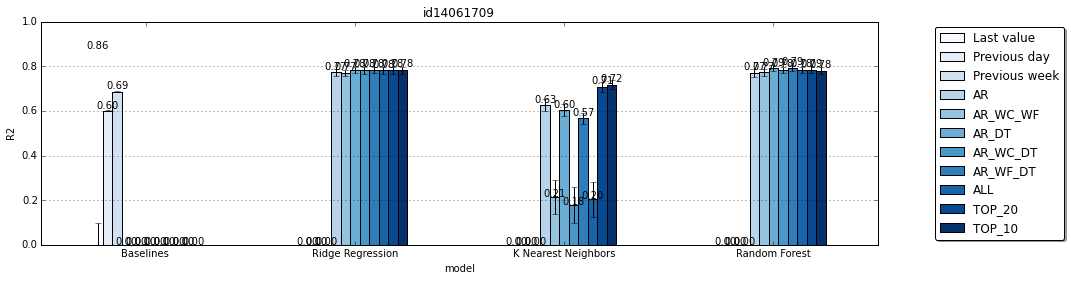

In [14]:
for sensor_id in validation_df.columns.levels[0]:
        
    err = validation_df.groupby(level=['dataset', 'model']).std()[sensor_id]['R2'].unstack(0)
            
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel('R2')
    plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Evaluation Scores for Each Horizon

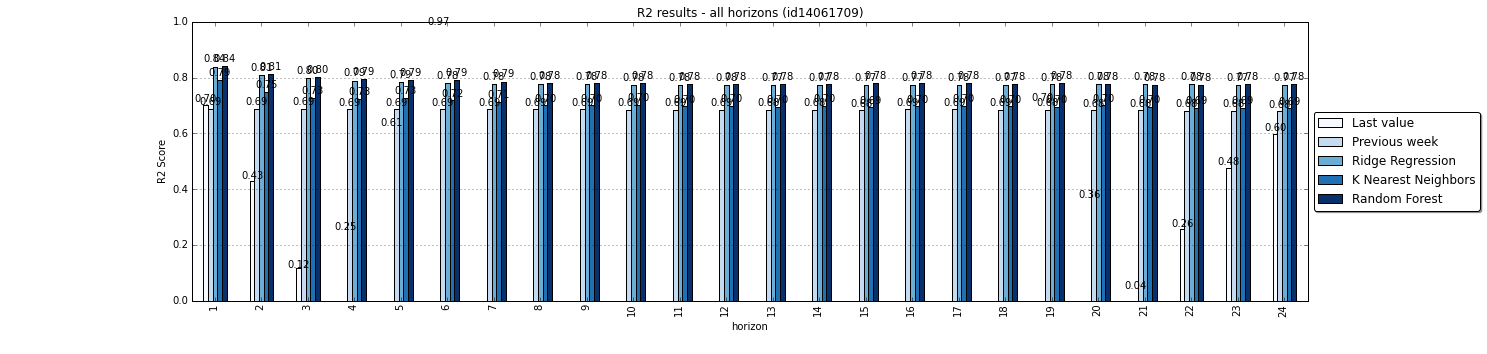

In [16]:
ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709']['R2'][['Last value', 'Previous week']].join(
    validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709']['R2']).plot(
    kind='bar', figsize=(20,5), title='R2 results - all horizons (id14061709)', ylim=(0,1), colormap='Blues')

for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')

ax.yaxis.grid()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.), ncol=5, fancybox=True, shadow=True)
#plt.legend(loc=4)
plt.ylabel('R2 Score')

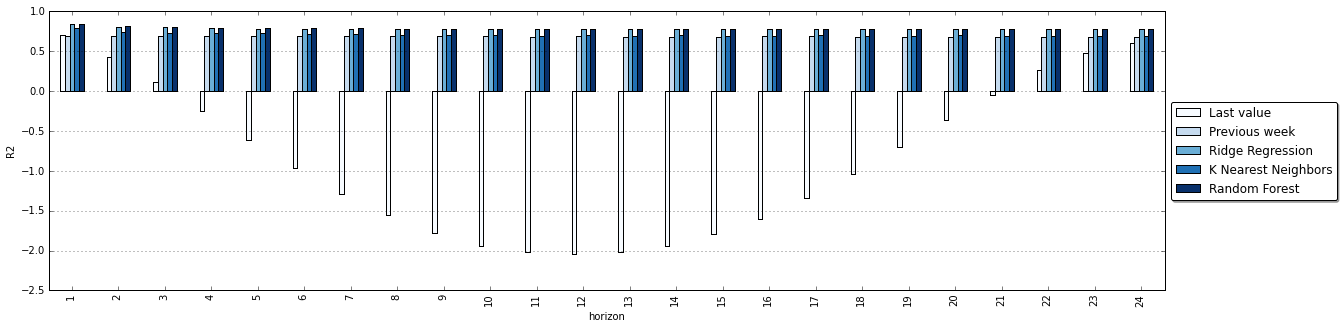

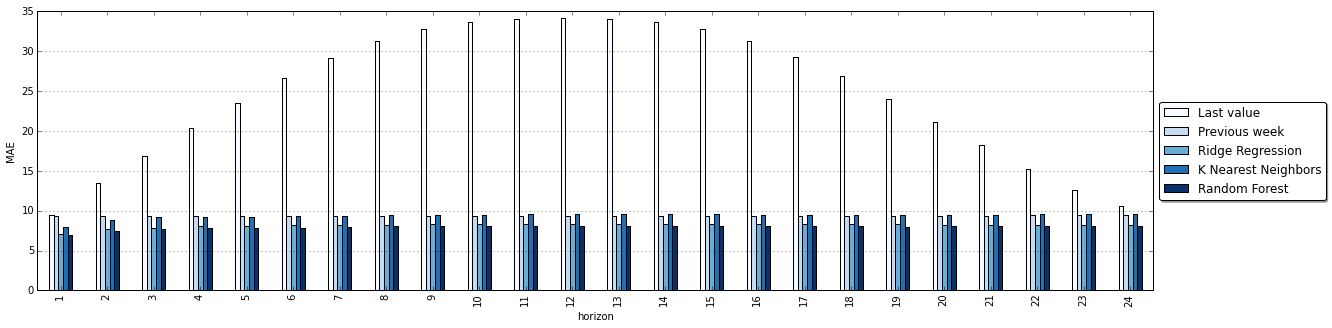

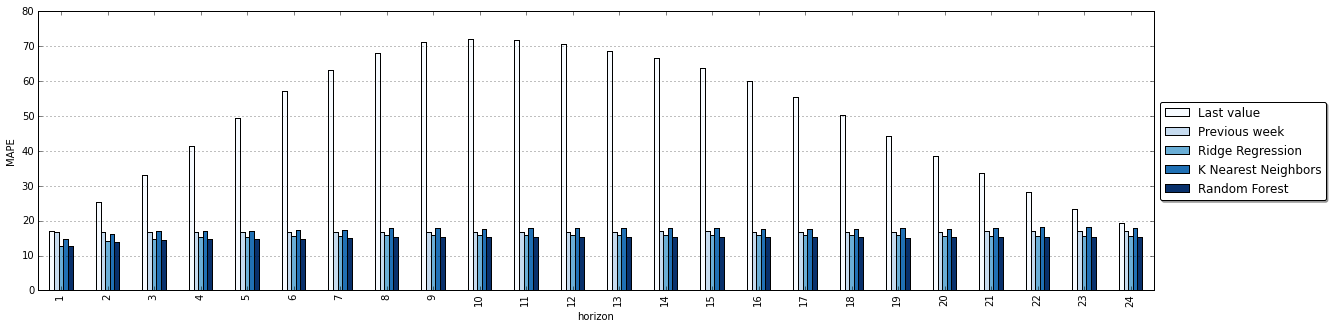

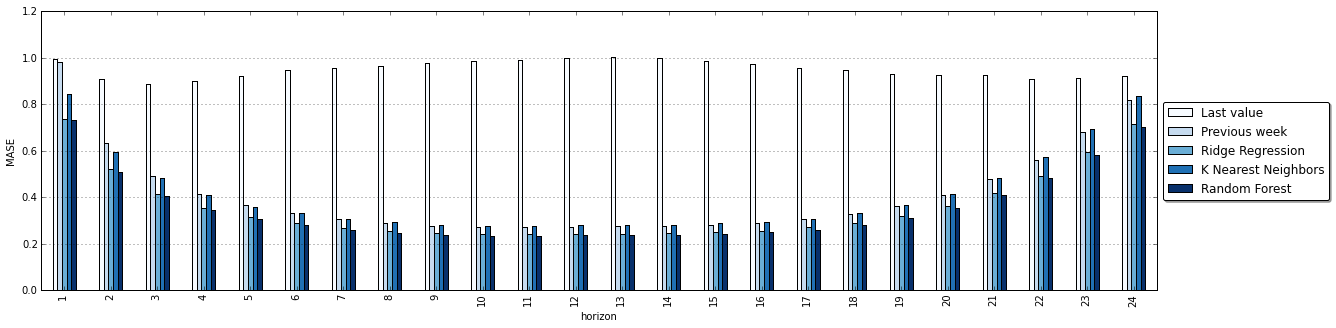

In [17]:
for measure in validation_df.columns.levels[1]:
    
    ax = validation_df.xs(["Baselines"], level=["model"]).unstack()['id14061709'][measure][['Last value', 'Previous week']].join(
        validation_df.xs(["TOP_20"], level=["dataset"]).unstack()['id14061709'][measure]).plot(
        kind='bar', figsize=(20,5), colormap='Blues')
    
    ax.yaxis.grid()   
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True)
    plt.ylabel(measure)
 

## Average Score by Sensors and Horizons

In [16]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                                   R2       MAE       MAPE  \
dataset             model                                                
Last value          Baselines            0.561509  1.675817  29.038490   
Previous day        Baselines            0.399188  2.035682  41.442958   
Previous week       Baselines            0.655598  1.569669  30.650789   
Measurement average Baselines            0.176525  3.042106  72.821162   
AR                  Ridge Regression     0.812825  1.276349  27.640770   
                    K Nearest Neighbors  0.785566  1.356553  29.801900   
                    Random Forest        0.823768  1.255085  29.553442   
SELECTED            Ridge Regression     0.755056  1.611357  39.967885   
                    K Nearest Neighbors  0.781093  1.401275  30.995457   
                    Random Forest        0.842835  1.194789  26.340880   

error metric                                 MASE  
dataset             model                          
Last value          Baselines            0.728761  
Previous day        Baselines            0.939339  
Previous week       Baselines            0.724327  
Measurement average Baselines            1.378100  
AR                  Ridge Regression     0.575318  
                    K Nearest Neighbors  0.616033  
                    Random Forest        0.565061  
SELECTED            Ridge Regression     0.711889  
                    K Nearest Neighbors  0.631593  
                    Random Forest        0.538496

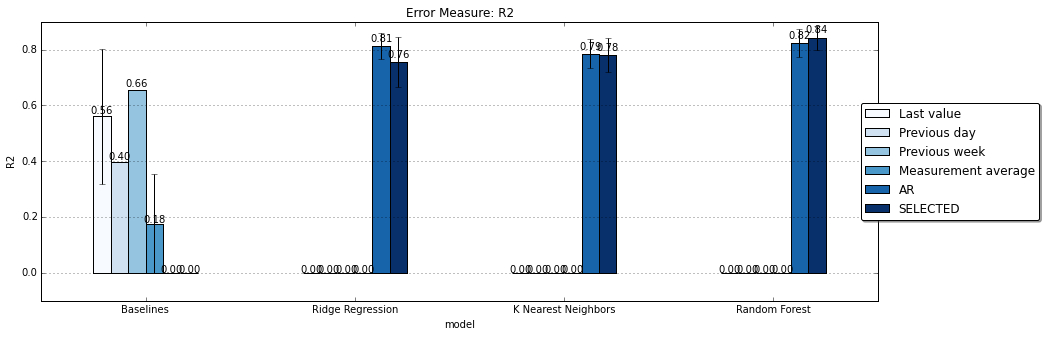

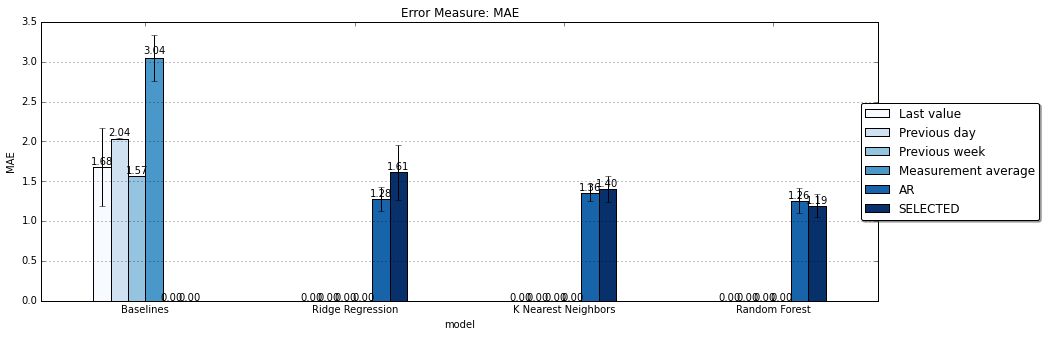

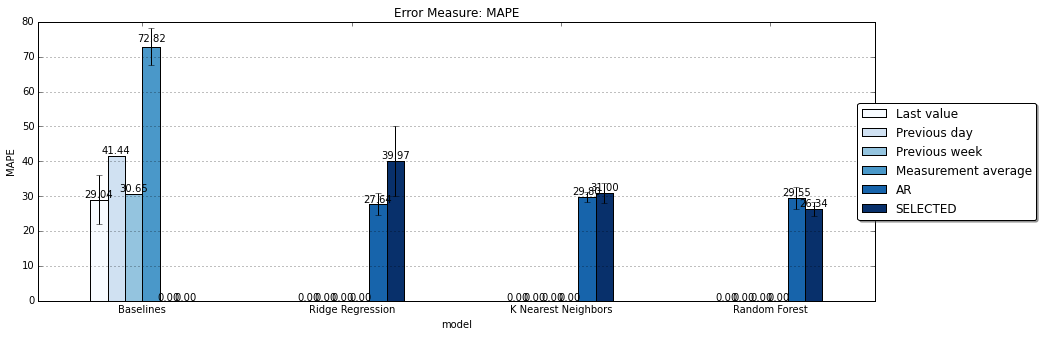

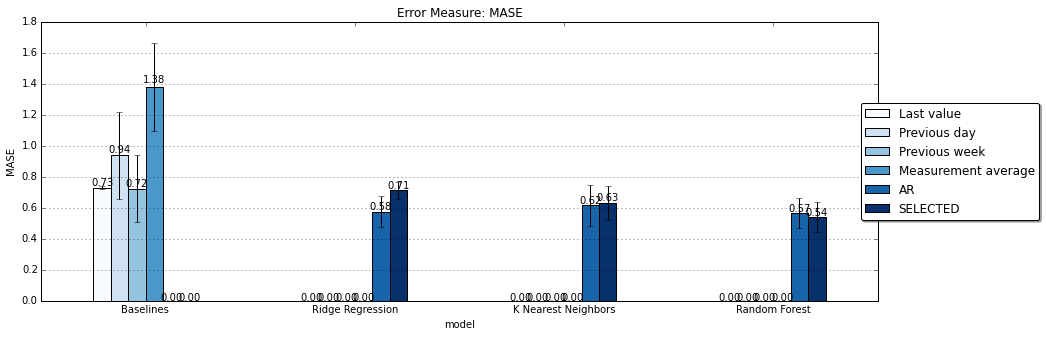

In [18]:
for measure in validation_df.columns.levels[1]:

    err = ax = validation_df.groupby(level=['dataset', 'model']).std().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0)
    
    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        yerr=err, kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.